In [1]:
from jax import vmap
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import time
from equinox_module import training_MODEL, create_DeepONet, save_MODEL, load_DeepONet

In [2]:
SEED = 10

BRANCH_INPUT_DIM  = 20
BRANCH_WIDTH      = 20
BRANCH_DEPTH      = 4
BRANCH_ACTIVATION = 'tanh'

TRUNK_INPUT_DIM   = 1
TRUNK_WIDTH       = 20
TRUNK_DEPTH       = 4
TRUNK_ACTIVATION  = 'tanh'

DEEPONET_WIDTH    = 50
# sine, cosine, relu, tanh, gelu, swish

In [3]:
HYPER_MODEL = {"TRUNK": {"input_dim": TRUNK_INPUT_DIM, 
               "output_dim": DEEPONET_WIDTH, 
               "width": TRUNK_WIDTH,
               "depth": TRUNK_DEPTH-1, 
               "act_func": TRUNK_ACTIVATION},
               "BRANCH": {"input_dim": BRANCH_INPUT_DIM, 
               "output_dim": DEEPONET_WIDTH+1, 
               "width": BRANCH_WIDTH,
               "depth": BRANCH_DEPTH-1, 
               "act_func": BRANCH_ACTIVATION}
            }

In [4]:
key = jr.PRNGKey(SEED)
key, subkey_model, subkey_w, subkey_w_test = jr.split(key, num=4)

In [5]:
model = create_DeepONet(key=subkey_model, HYPER_MODEL=HYPER_MODEL)

In [6]:
LEARNING_RATE = 4e-4
OPTIMIZER_NAME = 'adam'
# adabelief, adadelta, adan, adafactor, adagrad, adam, adamw,
# adamax, adamaxw, amsgrad, lion, nadam, nadamw, novograd, radam,
# rmsprop, sgd, sm3, yogi, polyak_sgd
MAXITER = 50_000
PRINT_EVERY = 5_000

LR_SCHEDULER = 'constant' # exponential or constant
LR_DECAY = 0.90
LR_STEP  = 1000

LBFGS_USE = 'on'
LBFGS_MAXITER = 10_000
LBFGS_PRINT_EVERY = 1_000
if LBFGS_USE != 'on':
    LBFGS_MAXITER = 0
    LBFGS_PRINT_EVERY = 0

### Differentiation Operator
$
\mathcal{G}: u \mapsto u'
$
#### Training Data:
Input functions: $\sin(wx) \mapsto \{\sin(wx_i)\}_{i=1}^{20}$ (discretization)

Output functions: $\mathcal{G}(\sin(wx)) = w\cos(wx)$

In [7]:
def input_function(w,x):
    return jnp.sin(w*x)

def output_function(w,x):
    return jax.grad(input_function,argnums=1)(w,x)

# def output_function(w,x):
    # return w*jnp.cos(w*x)

branch_sensors = jnp.linspace(-1,1,BRANCH_INPUT_DIM)
w_sample = jr.uniform(key=subkey_w, minval=0.1*jnp.pi, maxval=2*jnp.pi, shape=(100,))
w_sample_test = jr.uniform(key=subkey_w_test, minval=0.1*jnp.pi, maxval=2*jnp.pi, shape=(200,))

In [8]:
branch_input_data = vmap(lambda w: vmap(lambda x: input_function(w,x))(branch_sensors))(w_sample)
trunk_input_data  = jnp.linspace(-1,1,300)
trunk_output_data = vmap(lambda w: vmap(lambda x: output_function(w,x))(trunk_input_data))(w_sample)

branch_input_test = vmap(lambda w: vmap(lambda x: input_function(w,x))(branch_sensors))(w_sample_test)
trunk_input_test  = jnp.linspace(-1,1,600)
trunk_output_test = vmap(lambda w: vmap(lambda x: output_function(w,x))(trunk_input_test))(w_sample_test)

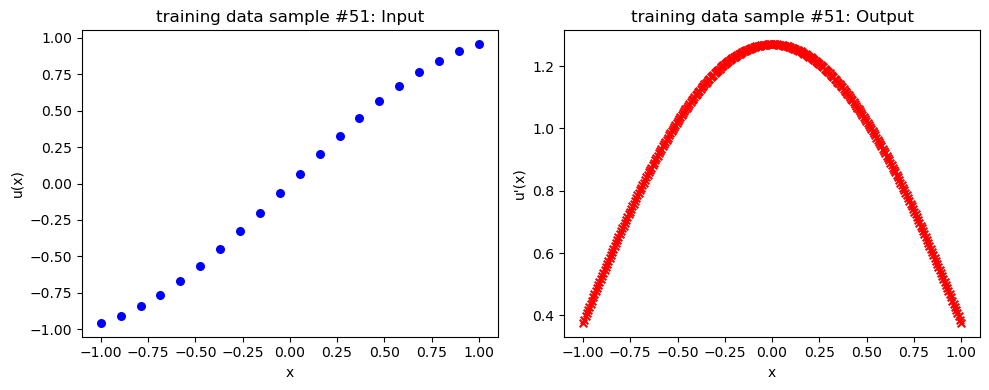

In [9]:
tr_idx = np.random.randint(100)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axe = axes.flatten()
axe[0].scatter(branch_sensors,branch_input_data[tr_idx],color='blue', marker='o', s=30)
axe[0].set_xlabel('x')
axe[0].set_ylabel('u(x)')
axe[0].set_title(f'training data sample #{tr_idx+1}: Input')
axe[1].scatter(trunk_input_data,trunk_output_data[tr_idx],color='red', marker='x', s=30)
axe[1].set_xlabel('x')
axe[1].set_ylabel("u'(x)")
axe[1].set_title(f'training data sample #{tr_idx+1}: Output')
fig.tight_layout()

In [10]:
HYPER_OPTIM = {"MAXITER": MAXITER, 
               "NAME": OPTIMIZER_NAME, 
               "LEARNING_RATE_SCHEDULER": LR_SCHEDULER, 
               "LEARNING_RATE_INITIAL": LEARNING_RATE, 
               "LEARNING_RATE_DECAY": LR_DECAY, 
               "LEARNING_RATE_STEP": LR_STEP, 
               "PRINT_EVERY": PRINT_EVERY,
               "LBFGS": {"USE": LBFGS_USE, "MAXITER": LBFGS_MAXITER, "PRINT_EVERY": LBFGS_PRINT_EVERY}
               }

In [12]:
def loss_fn(model):
    residual = vmap(lambda f: vmap(lambda x: model(f,x))(trunk_input_data[:,None]))(branch_input_data) - trunk_output_data
    return jnp.mean(jnp.sum((residual)**2,axis=1) / jnp.sum(trunk_output_data**2,axis=1))
    # return jnp.mean(residual**2)

In [13]:
start_time = time.time()
model, log_loss, log_minloss = training_MODEL(model, loss_fn, HYPER_OPTIM)
end_time = time.time()

Selected Optimizer is [ adam ], Initial Learning Rate is 4.00e-04
You are using [ constant ] learning rate
-------------------------TRAINING STARTS-------------------------
-----------------------------------------------------------------
Epoch   0K: loss = 1.0858e+00, minloss = 1.0858e+00, Time: 0.32s
Epoch   5K: loss = 3.5768e-04, minloss = 3.1846e-04, Time: 3.97s
Epoch  10K: loss = 3.8131e-05, minloss = 3.7438e-05, Time: 3.67s
Epoch  15K: loss = 2.1816e-05, minloss = 1.5301e-05, Time: 3.70s
Epoch  20K: loss = 9.6728e-06, minloss = 9.4603e-06, Time: 3.85s
Epoch  25K: loss = 1.9877e-05, minloss = 6.8179e-06, Time: 3.49s
Epoch  30K: loss = 7.4152e-06, minloss = 5.3592e-06, Time: 3.47s
Epoch  35K: loss = 4.4682e-06, minloss = 4.4465e-06, Time: 3.52s
Epoch  40K: loss = 4.6113e-06, minloss = 3.8276e-06, Time: 3.51s
Epoch  45K: loss = 6.5355e-06, minloss = 3.3007e-06, Time: 3.57s
Epoch  50K: loss = 4.2126e-06, minloss = 2.8503e-06, Time: 4.16s
----------------------------------------------

Avg. Relative L2 error     : 6.4961e-04


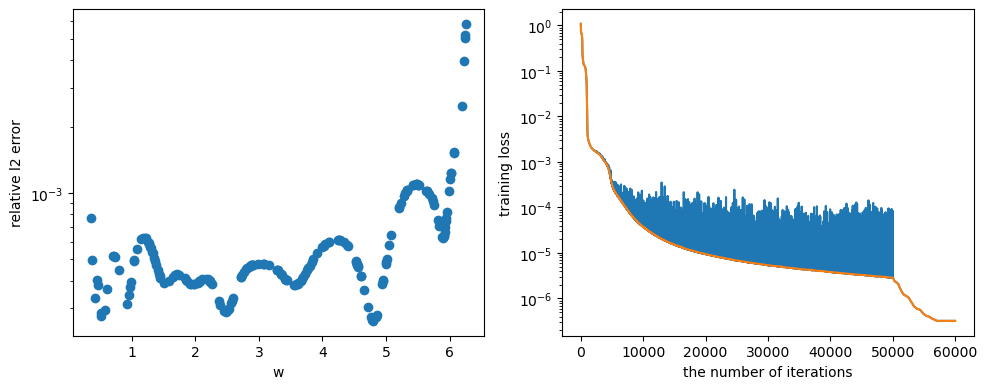

In [14]:
NN_pred_final = vmap(lambda f: vmap(lambda x: model(f,x))(trunk_input_test[:,None]))(branch_input_test)
# vmin, vmax = jnp.min(y_tt), jnp.max(y_tt)
rel_l2_error = jnp.sqrt(jnp.sum((trunk_output_test - NN_pred_final)**2,axis=1) / jnp.sum(trunk_output_test**2,axis=1))
print(f"Avg. Relative L2 error     : {jnp.mean(rel_l2_error):.4e}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(w_sample_test,rel_l2_error)
axes[0].set_yscale('log')
axes[0].set_xlabel('w')
axes[0].set_ylabel('relative l2 error')
axes[1].semilogy(log_loss)
axes[1].semilogy(log_minloss)
axes[1].set_xlabel('the number of iterations')
axes[1].set_ylabel('training loss')
plt.tight_layout()
# plt.suptitle(title_str + '\n')
plt.show()

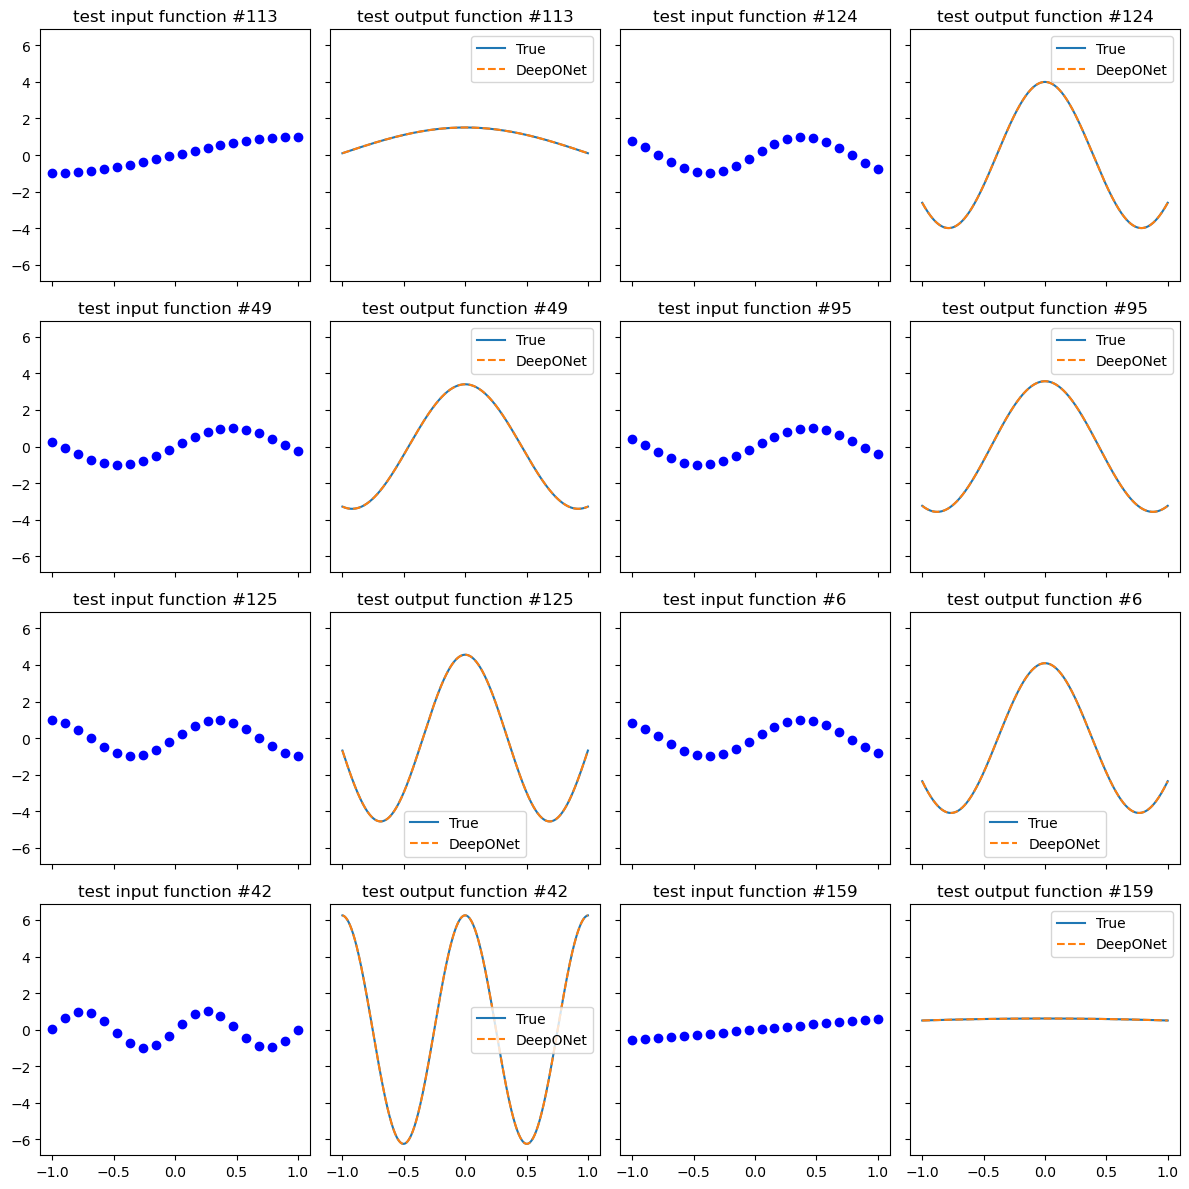

In [15]:
rnd_idx = np.random.permutation(200)
fig, axes = plt.subplots(4, 4, figsize=(12, 12), sharey=True, sharex=True)
axe = axes.flatten()
for i in range(len(axe)//2):
    tt_idx = rnd_idx[i]
    axe[2*i].plot(branch_sensors,branch_input_test[tt_idx],'ob')
    axe[2*i].set_title(f'test input function #{tt_idx+1}')
    axe[2*i+1].plot(trunk_input_test,trunk_output_test[tt_idx],label='True')
    axe[2*i+1].plot(trunk_input_test,trunk_output_test[tt_idx],'--',label='DeepONet')
    axe[2*i+1].set_title(f'test output function #{tt_idx+1}')
    axe[2*i+1].legend()
fig.tight_layout()

In [16]:
save_MODEL('DeepONet_Diff.eqx',HYPER_MODEL,model)

In [17]:
loaded_model = load_DeepONet('DeepONet_Diff.eqx')

Avg. Relative L2 error     : 6.4961e-04


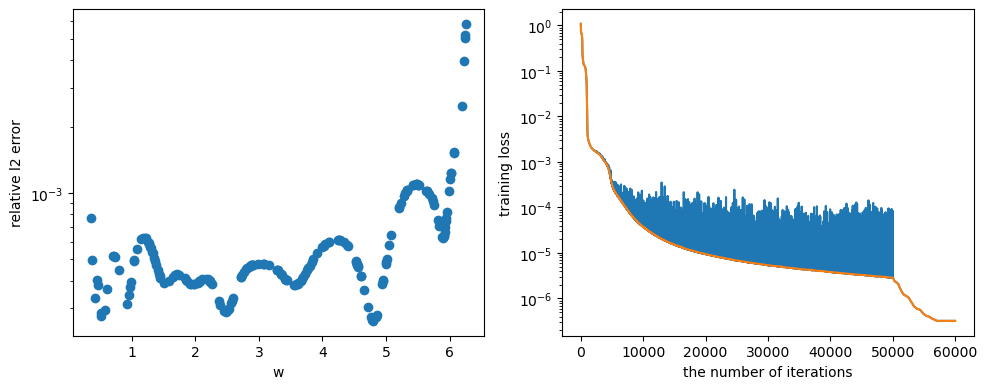

In [18]:
NN_pred_final = vmap(lambda f: vmap(lambda x: loaded_model(f,x))(trunk_input_test[:,None]))(branch_input_test)
# vmin, vmax = jnp.min(y_tt), jnp.max(y_tt)
rel_l2_error = jnp.sqrt(jnp.sum((trunk_output_test - NN_pred_final)**2,axis=1) / jnp.sum(trunk_output_test**2,axis=1))
print(f"Avg. Relative L2 error     : {jnp.mean(rel_l2_error):.4e}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(w_sample_test,rel_l2_error)
axes[0].set_yscale('log')
axes[0].set_xlabel('w')
axes[0].set_ylabel('relative l2 error')
axes[1].semilogy(log_loss)
axes[1].semilogy(log_minloss)
axes[1].set_xlabel('the number of iterations')
axes[1].set_ylabel('training loss')
plt.tight_layout()
# plt.suptitle(title_str + '\n')
plt.show()